In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import scipy.stats as stats
import scipy.ndimage
import altair as alt

alt.data_transformers.enable('csv')

%config InlineBackend.figure_format = 'retina'

First, load the dataset.

In [2]:
size = 100000
raw = pd.read_csv('flights-10m.csv', nrows=size)

In [3]:
raw.head(10)

,FlightDate,DepTime,DepDelay,ArrTime,ArrDelay,AirTime,Distance
0,2006-01-01,905.0,5.0,1229.0,19.0,350.0,2475.0
1,2006-01-02,1147.0,167.0,1546.0,216.0,343.0,2475.0
2,2006-01-03,853.0,-7.0,1208.0,-2.0,344.0,2475.0
3,2006-01-04,855.0,-5.0,1157.0,-13.0,331.0,2475.0
4,2006-01-05,857.0,-3.0,1153.0,-17.0,321.0,2475.0
5,2006-01-06,856.0,-4.0,1138.0,-32.0,320.0,2475.0
6,2006-01-08,857.0,-3.0,1208.0,-2.0,346.0,2475.0
7,2006-01-09,903.0,3.0,1210.0,0.0,334.0,2475.0
8,2006-01-10,853.0,-7.0,1149.0,-21.0,334.0,2475.0
9,2006-01-11,908.0,8.0,1200.0,-10.0,321.0,2475.0


Below, change the configuration for the fields we want to look at.

In [53]:
active = "AirTime"
passive = "ArrDelay"
active_range = [0, 500]
passive_range = [-20, 50]

pixels = 500
bins = 25

In [54]:
df = raw[
    (active_range[0] <= raw[active]) & (raw[active] < active_range[1]) &
    (passive_range[0] <= raw[passive]) & (raw[passive] < passive_range[1])]

## Compute count matrix

Now, compute the count matrix for the active and passive dimensions. For this, aggregate into a binned matrix. 

In [55]:
bins_active = np.linspace(active_range[0], active_range[1], pixels + 1)
bins_passive = np.linspace(passive_range[0], passive_range[1], bins + 1)

hist, xedges, yedges = np.histogram2d(df[active], df[passive], bins=(bins_active, bins_passive))

In [56]:
# add 0s as the first row

pdf = np.vstack([np.zeros(bins), hist])

In [57]:
def show(a, size=(6,6)):
    """ Helper function to show a matrix. """
    print("Shape:", a.shape)
    plt.figure(figsize=size)
    plt.imshow(a, aspect='auto')
    plt.colorbar()

Let's look at the PDF of the count matrix. 

Shape: (501, 25)


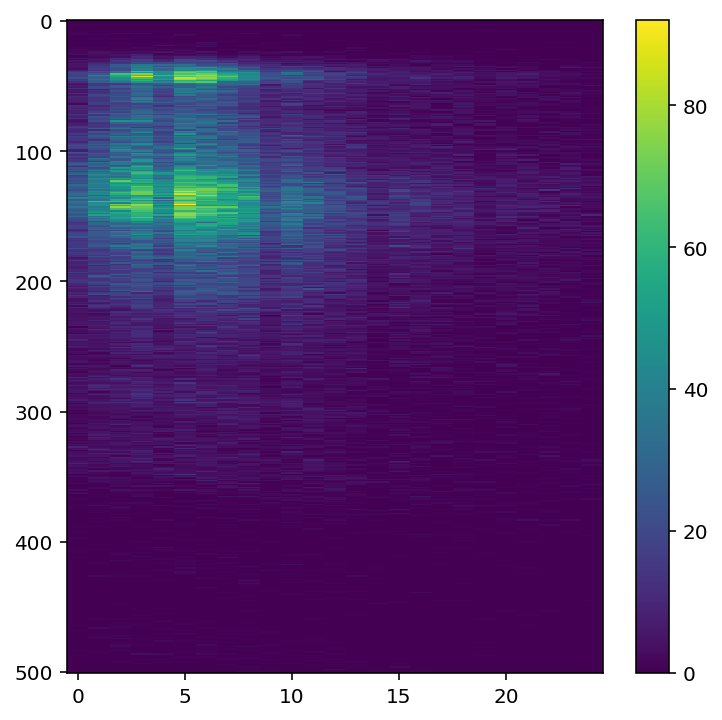

In [58]:
show(pdf)

Shape: (25, 501)


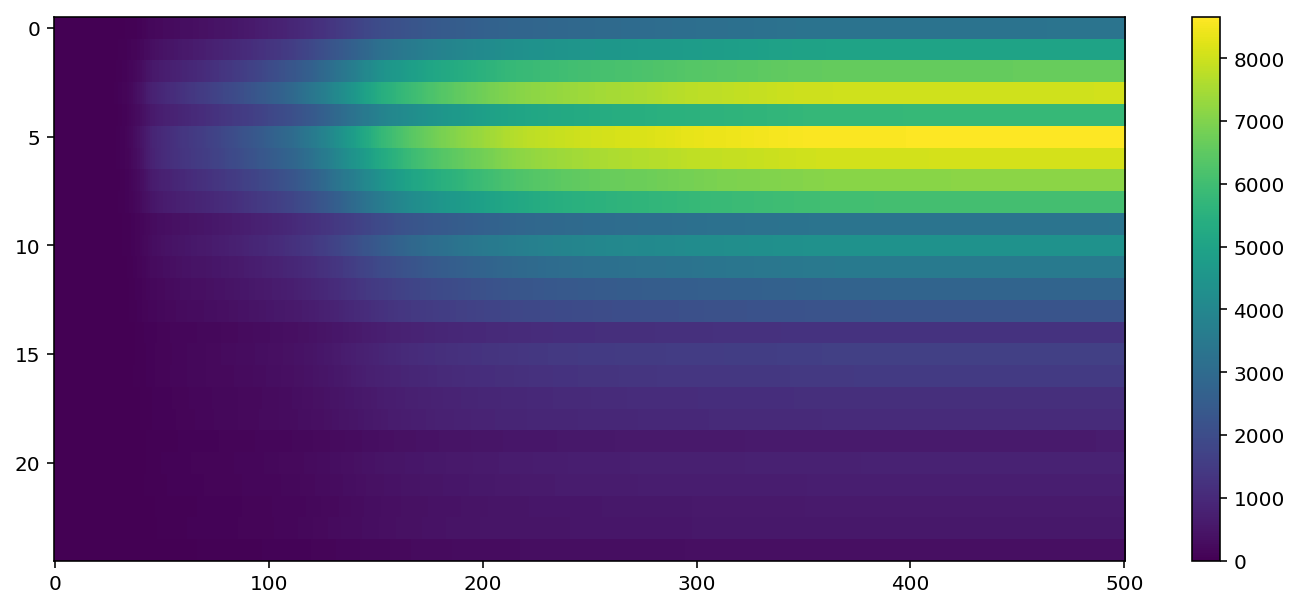

In [64]:
show(np.cumsum(pdf, axis=0).T, (12, 5))

## Compute cumulative count matrix

Now, compute a cumulative count matrix. The cumulative version is computed along the active dimension. 

In [321]:
cdf = np.cumsum(pdf, axis=0)

Shape: (501, 20)


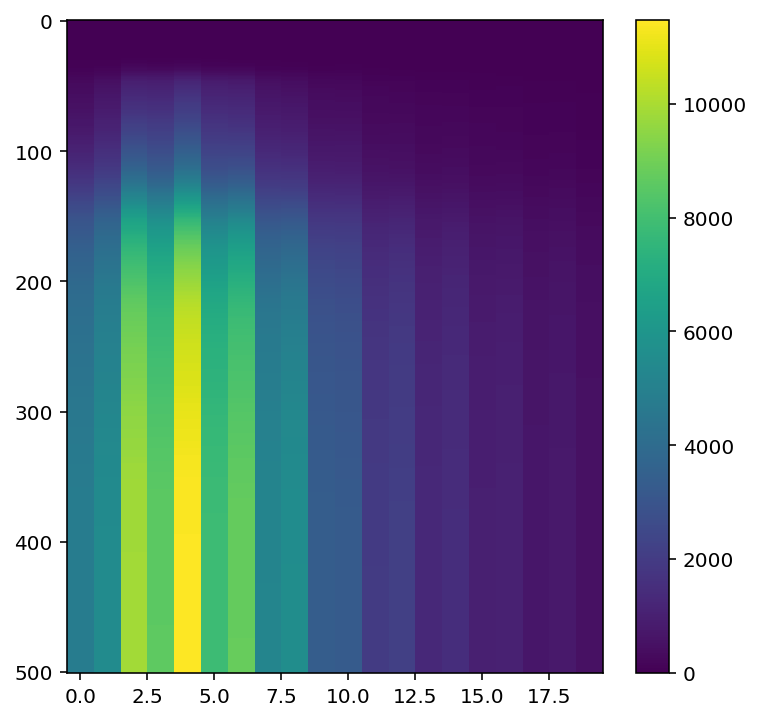

In [322]:
show(cdf)

## Interpolation from low resolution

Okay, now that we have a cumulative count matrix, we could compute the conditional histograms from this. However, the count matrix is a bit large. Let's see how well we could do the same from a lower resolution version. 

To do this, we first create a low resolution cdf where we pick every k rows. Then we use simple linear interpolation along the columns to get back something as close as possible to the original cumulative count matrix. 

Width 25.0
Row indexes [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]
Shape: (21, 20)


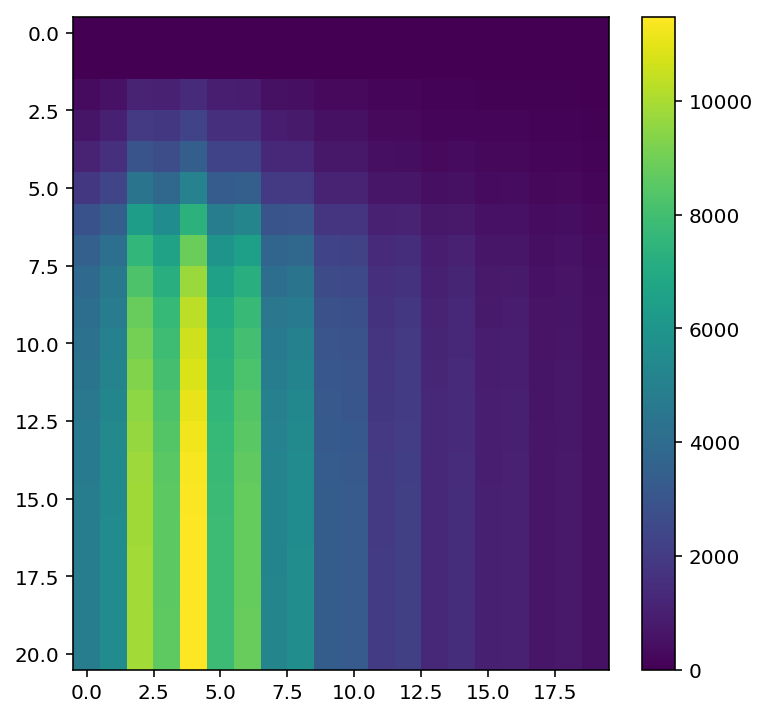

In [323]:
print("Width", pixels/bins)
idx = list(range(0,pixels+1, int(pixels/bins)))
print("Row indexes", idx)
low_res = cdf[idx, :]
show(low_res)

In [324]:
# compute the interpolated cdf as the same dimensions as the high resolution cdf

# i = interpolate.interp1d(np.arange(pixels), cdf, kind="linear", axis=0)
p = np.arange(0, pixels+1, pixels/bins);
print("Value locations: ", p)
i = interpolate.interp1d(p, low_res, kind="linear", axis=0)

to_interpolate = np.arange(0, pixels+1)
interpolated_cdf = i(to_interpolate)

assert interpolated_cdf.shape == cdf.shape, f"Interpolated matrix does not have the right dimensions {interpolated_cdf.shape} != {cdf.shape}"

Value locations:  [  0.  25.  50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300. 325.
 350. 375. 400. 425. 450. 475. 500.]


Shape: (501, 20)


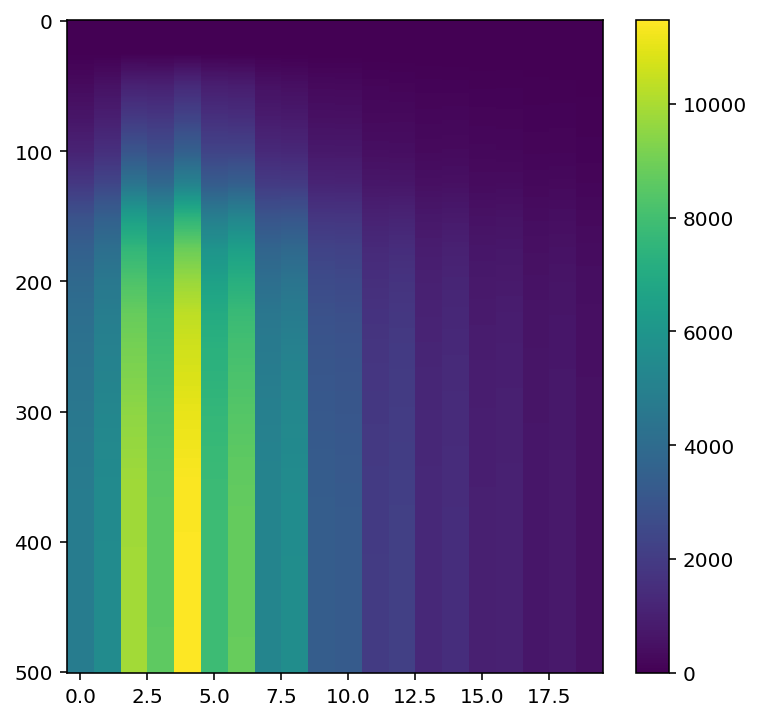

In [325]:
show(interpolated_cdf)

This looks pretty good but how close is it actually to the original cumulative count matrix?

## Evaluation

First, let's visualize the difference betwen the interpolation and the true CDF. 

Shape: (501, 20)


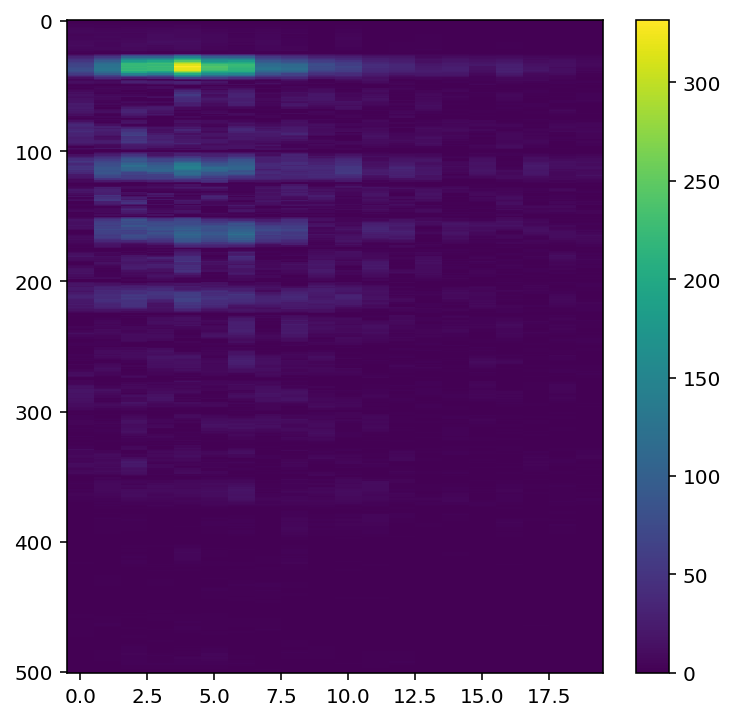

In [326]:
show(np.abs(cdf - interpolated_cdf))

In [327]:
data = []

min_brush = int(pixels / bins)

print("Minimum brush size:", min_brush)

for size in range(min_brush, pixels, 20):
    for start in range(pixels - size):
        end = start + size
        
        hist_a = interpolated_cdf[end] - interpolated_cdf[start]
        hist_b = cdf[end] - cdf[start]
        d = stats.wasserstein_distance(range(bins), range(bins), hist_a, hist_b)
        
        data.append([start, size, d, hist_a.sum(), hist_b.sum()])
        
distances = pd.DataFrame(data, columns=["start", "size", "distance", "sum_a", "sum_b"])

Minimum brush size: 25


In [328]:
print(distances.shape)
distances.head()

(5880, 5)


,start,size,distance,sum_a,sum_b
0,0,25,0.000000,182.00,182.0
1,1,25,0.628789,517.32,216.0
2,2,25,0.616065,852.64,257.0
3,3,25,0.483724,1187.96,324.0
4,4,25,0.517059,1523.28,414.0


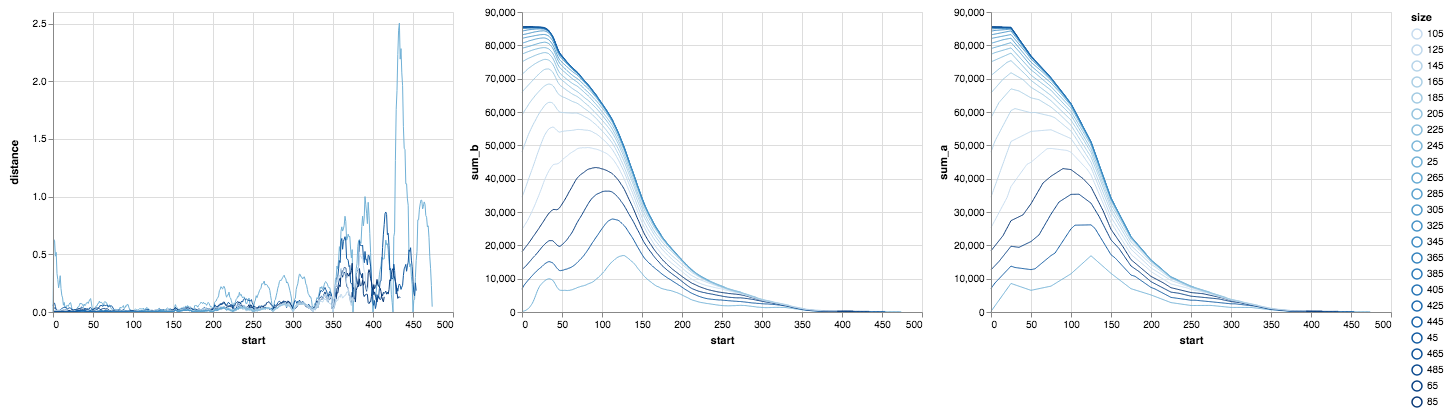

In [331]:
filtered_distances = distances[distances.sum_b > size * 0.05]

alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="distance:Q",
    color="size:O"
) | alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="sum_b:Q",
    color="size:O"
) | alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="sum_a:Q",
    color="size:O"
)